# **Recurrent Neural Network - Description d'images**

Le but de cet exercice est la description d'images ou écriture d'une légende pour une image. On va utiliser le dataset Flickr8K. Pour ceux qui ont un ont des machines de guerres ou qui ont envie de donner des sous à AWS pour du GPU, vous pouvez utiliser le Flickr30K si vous voulez.èresderrière

Hésitez pas à bien lire jusqu'à la fin pour avoir une vue d'ensemble de ce qu'on va faire plutôt que "patauger avec des oeillères derrière les fagots" comme on dit.

In [1]:
# usuelles
import numpy as np
import pandas as pd
import string
import pickle as pkl

from re                             import sub
from random                         import sample
from tqdm                           import tqdm
from collections                    import Counter

#image display
from IPython.display                import Image, display

#sklearn
from sklearn.model_selection        import train_test_split

#keras
from keras.utils                    import to_categorical
from keras.applications.xception    import Xception, preprocess_input
from keras.preprocessing.sequence   import pad_sequences
from keras.preprocessing.image      import load_img, img_to_array
from keras.layers                   import Input, Dense, LSTM, Embedding, Dropout
from keras.models                   import Model, load_model
from keras.layers.merge             import add, concatenate

## **1. Les données**

On va donc se servir de Flickr8K que vous pouvez trouver sur [kaggle](https://www.kaggle.com/adityajn105/flickr8k) (ou ailleurs d'ailleurs, ou même tout simplement dans le dossier data...). Il contient un peu plus de 8000 images et dans un second fichier une série de légendes associées à chaque image.

1. De quoi est composé le dossier `data/flickr8k` ? Combien y a-t-il d'images ? Combien y a-t-il de légendes par image ?
2. Créer 2 variables `data_path` et `img_path` contenant les chemins vers les données et vers les images

In [2]:
data_path = "data/flickr8k/"
img_path = "data/flickr8k/Images/"

## **2. Les légendes**

Il faut bien comprendre que l'objectif va être de prédire une légende pour une image. C'est donc le Y de notre problème. En revanche on ne va pas prédire toute la légende d'un coup mais mot à mot...to be continued.

### **2.1. Import et formatage**
1. Charger les légendes "captions.txt" dans un dataframe pandas : vérifier que vous avez le bon nombre d'images dans le df par rapport au dossier
2. On va maintenant faire le prétraitement de ces données textuelles.
>- Mettre tout en minuscule
>- Supprimer la ponctuation
>- Ajouter au début de chaque séquence `<start>` et à la fin `<end>` : pourquoi introduit-on ces balises de début et de fin ?
3. Créer un dictionnaire avec :
- pour clés les id des images
- pour valeurs des listes contenant toutes les légendes
4. Créer une fonction qui affiche une image et ses légendes à partir d'un id

In [3]:
# df captions
df = pd.read_csv(data_path+"captions.txt")
print(len(df.image.unique()), "images et", len(df.image.unique())*5, "légendes")
df

8091 images et 40455 légendes


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [4]:
# text preprocessing
df.caption = df.caption.apply(lambda s : "<start> "+s.lower().translate(str.maketrans('', '', string.punctuation))+" <end>")
df

,image,caption
0,1000268201_693b08cb0e.jpg,<start> a child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,<start> a girl going into a wooden building <...
2,1000268201_693b08cb0e.jpg,<start> a little girl climbing into a wooden p...
3,1000268201_693b08cb0e.jpg,<start> a little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,<start> a little girl in a pink dress going in...
...,...,...
40450,997722733_0cb5439472.jpg,<start> a man in a pink shirt climbs a rock fa...
40451,997722733_0cb5439472.jpg,<start> a man is rock climbing high in the air...
40452,997722733_0cb5439472.jpg,<start> a person in a red shirt climbing up a ...
40453,997722733_0cb5439472.jpg,<start> a rock climber in a red shirt <end>


In [5]:
# dictionnaire {id:[liste des légendes]}
desc = {img_id : list() for img_id in df.image.unique()}
df.apply(lambda row : desc[row[0]].append(row[1]), axis = 1, raw=True)
desc['1000268201_693b08cb0e.jpg']

['<start> a child in a pink dress is climbing up a set of stairs in an entry way  <end>',
 '<start> a girl going into a wooden building  <end>',
 '<start> a little girl climbing into a wooden playhouse  <end>',
 '<start> a little girl climbing the stairs to her playhouse  <end>',
 '<start> a little girl in a pink dress going into a wooden cabin  <end>']

In [6]:
def image_captions(img_id):
    display(Image(img_path+img_id, width=200))
    print(desc[img_id])

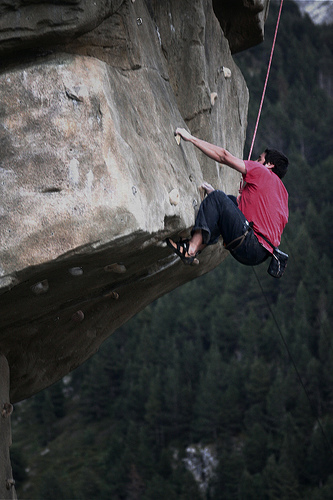

['<start> a man in a pink shirt climbs a rock face <end>', '<start> a man is rock climbing high in the air  <end>', '<start> a person in a red shirt climbing up a rock face covered in assist handles  <end>', '<start> a rock climber in a red shirt  <end>', '<start> a rock climber practices on a rock climbing wall  <end>']


In [7]:
image_captions('997722733_0cb5439472.jpg')

### **2.2. Création des échantillons test, validation et train**

Créer les échantillons train, validation et test avec :
- 85% des images dans le train
- 9% images dans le validation
- 6% images dans le test

1. Créer d'abord les découpages train/val/test sur les id des images (vous devez donc avoir 3 listes d'ids d'images)
2. Créer les échantillons train/val/test avec les images et leurs légendes à partir du dataframe chargé au début en sélectionnant les ids correspondant (ids créés dans la question juste avant, si c'est pas clair...)
3. Créer aussi les dictionnaires associés

Sur un projet à plus long terme, il serait judicieux de les sauvegarder dans des dossiers/fichiers distincts. Mais là on va pas le faire.

In [55]:
# découpage train/val/test des images
img_train, img_tmp = train_test_split(list(desc.keys()), test_size = 0.15)
img_test, img_valid = train_test_split(img_tmp, test_size = 0.4)

print(len(img_train), len(img_valid), len(img_test))

6877 486 728


In [9]:
# découpage du df images avec leurs captions
train = df[df.image.isin(img_train)]
valid = df[df.image.isin(img_valid)]
test = df[df.image.isin(img_test)]

print(train.shape, valid.shape, test.shape)

(34385, 2) (2005, 2) (4065, 2)


In [10]:
# découpage du dico
train_desc = {img: desc[img] for img in img_train}
valid_desc = {img: desc[img] for img in img_valid}
test_desc = {img: desc[img] for img in img_test}

print(len(train_desc), len(valid_desc), len(test_desc))

6877 401 813


### **2.3. Tokenization**

Dans cette section, on va faire ce qu'on a déjà fait, à savoir, encoder les mots en valeurs numériques. Il y a des méthodes et des classes spécifiques prévues pour ça mais c'est plus drôle de le faire soi, n'est-ce pas ? Et surtout ça oblige à comprendre ce qu'on fait, et pourquoi.
1. Créer une liste `words` contenant tous les mots de toutes les images de **l'échantillon d'entraînement**
2. En utilisant par exemple `Counter` de `collections` et la méthode `most_common`, récupérer la liste qu'on nommera `vocab` (pour vocabulaire...) des mots triés par occurences décroissantes et qui apparaissent **plus de 10 fois**. On veut faire un modèle prédictif qui prédira le mot suivant dans chaque légende, on ne veut donc pas de mots ayant de si faibles probabilité d'apparition.
3. Créer un mapping des mots en entiers, c'est-à-dire, 2 dictionnaires en faisant attention à bien faire commencer les indices à 1 (pour toujours cette histoire de padding) : 
>- un `word_to_idx` avec les mots comme clés et les entiers correspondants comme valeurs
>- un `idx_to_word` avec les entiers comme clés et les mots correspondants comme valeurs
4. Ajouter dans les 2 dictionnaires la correspondance avec le caractère padding `<pad>`. Créer la variable `vocab_len` qui compte le nombre de mots de votre vocabulaire.
5. Trouver de la manière qui vous plaira, la longueur maximale `max_length` (en nombre de mots) des légendes. On en aura besoin pour savoir combien de 0 ajouter lors de l'étape du *padding*.

In [12]:
# liste de tous les mots et longueur maximale des légendes
words = []
max_length = 0
for img, img_caps in train_desc.items(): 
    for cap in img_caps:
        cap_words = cap.split()
        words += cap_words
        max_length = max(max_length, len(cap_words))
print(max_length, len(words))

38 439341


In [67]:
# comptage des mots, tri par occurrence et suppression des mots peu présents
word_count = Counter(words)
vocab = [wd for wd,cnt in word_count.most_common() if (cnt>=5 and len(wd)>1 and wd.isalpha())]
len(vocab)

2742

In [14]:
# dictionnaires de correspondance mot <-> entier
word_to_idx = {wd:idx+1 for idx,wd in enumerate(vocab)}
idx_to_word = {idx+1:wd for idx,wd in enumerate(vocab)}

In [15]:
# ajout caractère padding
word_to_idx['<pad>'] = 0
idx_to_word[0] = '<pad>'

# on a donc ajouté un mot dans le vocabulaire, attention à la longueur...
vocab_len = len(vocab)+1

In [16]:
# test du mapping
print(idx_to_word[word_to_idx['a']], 
      idx_to_word[word_to_idx['girl']],
      idx_to_word[word_to_idx['cat']],
      idx_to_word[word_to_idx['floor']],
      idx_to_word[word_to_idx['<pad>']],
      idx_to_word[word_to_idx['<start>']],
      idx_to_word[word_to_idx['<end>']])

a girl cat floor <pad> <start> <end>


### **2.4. Le retour du _word embedding_**

Oui c'est un passage obligé, on va encoder nos mots non sous forme d'entiers mais sous forme de vecteurs de valeurs réelles. Pour ça on va de nouveau utiliser un embedding layer dans notre modèle. La seule différence, c'est qu'on va compliquer un peu les choses : dans l'analyse de sentiment on s'est pas trop embêté à savoir comment la conversion était faite, là on va préciser quelle matrice de poids servira à calculer les nouveaux vecteurs, à savoir une des matrices pré-entraînées des modèles GloVe. Pour en savoir un peu plus : https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db

1. Récupérer les vecteurs GloVe ici https://nlp.stanford.edu/projects/glove/. Prendre [glove.6B.zip](http://nlp.stanford.edu/data/glove.6B.zip) qui fait déjà 800 Mo...il y a 4 fichiers dans le zip, on va prendre 'glove.6B.200d.txt'  
Voilà à quoi ressemble une ligne "the -0.071549 0.093459 0.023738 ..." avec donc 200 valeurs pour décrire chaque mot.
2. Créer, en lisant ligne par ligne, le fichier .txt un dictionnaire `embed_dic` dans lequel les clés sont les mots et les valeurs sont les vecteurs associés (c'est-à-dire des `array` de taille (200,) contenant les 200 nombres décrivant chaque mot)
3. Créer la matrice de *word embedding* :
>- initialiser `embed_mat` un `array` de "0" de taille (nombre_de_mots_dans_le_vocabulaire, 200)
>- pour chaque mot du vocabulaire, remplacer la ligne de `embed_mat` par le vecteur associé (qu'on a stocké juste avant dans `embed_dic`)

In [17]:
embed_dic = {}
with open('data/GloVe/glove.6B.200d.txt', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        embed_dic[word] = np.asarray(values[1:], dtype='float32')

In [18]:
embed_mat = np.zeros((vocab_len, 200))
for wd, ix in word_to_idx.items():
    if wd in embed_dic:
        embed_mat[ix] = embed_dic.get(wd)

Voilà bravo, on a tout le nécessaire pour l'encodage, seulement, c'est pas pour tout de suite. On va s'attaquer au traitement des images d'abord. Rassurez vous, on y viendra.


## **3. Les images**

Les images sont les inputs de notre modèle donc comme tout input, va falloir en faire des vecteurs. Le but de cette étape est donc de transformer les images en vecteurs de taille fixe (si possible pas trop grande !) contenant l'information présentes dans les images (features).

"Ok mais comment transformer une image en un vecteur qui contient l'information présente dans cette image ?" me direz-vous. "Dites-moi, ce serait pas exactement le rôle des CNN ?" répondrai-je. L'idée va ainsi être d'utiliser un CNN pour récupérer un *feature vector* de chaque image.

"D'accord mais on va pas entraîner un modèle pour reconnaître n'importe quelle image ?!"s'exclamèrent-ils en coeur. "Non, c'est vrai, on va gentiment profiter de ceux qui l'ont déjà fait". La méthode c'est le *transfer learning* : on va pas recréer mais plutôt utiliser un existant. Vous avez l'embarras du choix : VGG16/VGG19 (le vainqueur sur ImageNet, à l'époque...), InceptionV3 (un des plus légers !). La liste est longue et elle est là https://keras.io/api/applications/.

Comme on fait tout ça en local, je vous propose d'utiliser `Xception` (qui est dérivé de InceptionV3 en étant meilleur) pour aller plus vite mais vous êtes libres de faire comme vous voulez !
1. Charger le modèle `Xception` de keras.
2. Afficher le summary du modèle : regarder les dernières couches et se rappeler pourquoi on fait ça, ah oui, pour avoir un vecteur...qu'est-ce qu'il faut faire ?
3. Créer avec la classe `Model` votre modèle qui aura les mêmes input que Xception mais des output différents : on va supprimer la dernière couche fully connected de la fin et et donc s'arrêter à l'avant dernier layer dont les outputs sont des vecteurs de longueur 2048. "Freezer" les paramètres de votre modèle en utilisant l'attribut `trainable` des la classe `layer`
4. Utilisation de votre modèle pour extraire les features c'est-à-dire passer chaque image dans votre modèle pour récupérer le feature vector taille 2048 en sortie. Il faut donc faire, pour chaque image :
>- En utilisant `load_img` et `img_to_array` de `keras.preprocessing` charger l'image et la transformer en un array **aux bonnes dimensions** (c'est-à-dire celles des inputs du modèle Xception...)
>- Faire le preprocessing de l'image en utilisant la fonction `preprocess_input` du module `keras.applications.xception`
>- Récupérer le *feature vector* de l'image en faisant un predict avec votre modèle
>- Faites un reshape du *feature vector* pour qu'il soit de taille (2048,)
>- Stocker tout ça dans un dictionnaire `img_features` avec pour clé les id des images
>- Sauvegarder avec pickle ce dictionnaire pour pas avoir à se taper les prédictions à chaque fois parce que c'est long quand même...

In [19]:
# chargement d'Xception
model = Xception(weights="imagenet")

In [20]:
#model.summary()

In [21]:
img_feat_extractor = Model(model.input, model.layers[-2].output)
#img_feat_extractor.summary()

```python
img_features = dict()

for img in tqdm(desc.keys()):
    im = load_img(img_path+img, target_size=(299, 299))
    im = img_to_array(im)
    im = np.expand_dims(im, axis=0)
    im = preprocess_input(im)
    feature = img_feat_extractor.predict(im, verbose=0)
    img_features[img] = feature.reshape(2048)
    
pkl.dump(img_features, open('img_features_xception.pkl', 'wb'))
```

In [22]:
with open('img_features_xception.pkl','rb') as f:
    img_features = pkl.load(f)

## **4. Préparation des données avec un Data Generator**

### **4.1 Pourquoi un Data Generator ?**
Ça fait un moment qu'on est sur la préparation, c'est vrai, mais cette étape là est fondamentale. On entent ici préparer nos données (déjà pretraitées) pour les mettre dans le format qui conviendra à notre modélisation. On va les rendre digeste pour notre modèle quoi.

Quels sont les inputs et les outputs de notre modèle ? Les images et les légendes.

Comment prédit-on une légende ? Je vous l'ai dit dès le début, on va faire de la prédiction **mot à mot**.

Comment ça se passe alors ? Ça se passe comme ça.

|   | X    =    image     |       +   légende partielle                       | Y = target |
|---|--------------------:|:--------------------------------------------------|:------:|
| 1 | img_feature_vector1 | \<start>                                          | the    |
| 2 | img_feature_vector1 | \<start> the                                      | girl   |
| 3 | img_feature_vector1 | \<start> the girl                                 | sat    |
| 4 | img_feature_vector1 | \<start> the girl sat                             | on     |
| 5 | img_feature_vector1 | \<start> the girl sat on                          | the    |
| 6 | img_feature_vector1 | \<start> the girl sat on the                      | floor  |
| 7 | img_feature_vector1 | \<start> the girl sat on the floor                | \<end> |
| 8 | img_feature_vector2 | \<start>                                          | a    |
| 9 | img_feature_vector2 | \<start> a                                        | cat   |
| 10 | img_feature_vector2 | \<start> a cat                                   | play    |
| 11 | img_feature_vector2 | \<start> a cat play                              | with     |
| 12 | img_feature_vector2 | \<start> a cat play with                         | a    |
| 13 | img_feature_vector2 | \<start> a cat play with a                       | red  |
| 14 | img_feature_vector2 | \<start> a cat play with a red                   | ball |
| 14 | img_feature_vector2 | \<start> a cat play with a red ball              | on |
| 14 | img_feature_vector2 | \<start> a cat play with a red ball on           | the |
| 14 | img_feature_vector2 | \<start> a cat play with a red ball on the       | grass |
| 14 | img_feature_vector2 | \<start> a cat play with a red ball on the grass | \<end> |


En input on met l'image (enfin son feature vector de taille 2048) plus une partie de la légende et en output on met le mot suivant correspondant. Voilà l'idée générale. Il reste juste à encoder les mots sous forme numérique et ajouter des 0 pour que les inputs aient tous la même taille.

Dans l'exemple présenté ici, on a 2 images dans l'échantillon d'entraînement, la longueur max des séquences est de 11 et le vocabulaire est `[the, <start>, <end>, on, girl, sat, floor, cat, play, with, red, ball, grass]` donc en encodant avec les indices comme on l'a fait précédemment, ça donnerait :

| Étapes   | INPUT    =    image     |       +   légende             | OUTPUT = target |
|----|--------------------:|:------------------------------|:------:|
| 1  | img_feature_vector1 | \[2,0,0,0,0,0,0,0,0,0,0\]     | 1    |
| 2  | img_feature_vector1 | \[2,1,0,0,0,0,0,0,0,0,0\]     | 5   |
| 3  | img_feature_vector1 | \[2,1,5,0,0,0,0,0,0,0,0\]     | 6    |
| 4  | img_feature_vector1 | \[2,1,5,6,0,0,0,0,0,0,0\]     | 4     |
| 5  | img_feature_vector1 | \[2,1,5,6,4,0,0,0,0,0,0\]     | 1    |
| 6  | img_feature_vector1 | \[2,1,5,6,4,1,0,0,0,0,0\]     | 7  |
| 7  | img_feature_vector1 | \[2,1,5,6,4,1,7,0,0,0,0\]     | 3 |
| 8  | img_feature_vector2 | \[2,0,0,0,0,0,0,0,0,0,0\]     | 1    |
| 9  | img_feature_vector2 | \[2,1,0,0,0,0,0,0,0,0,0\]     | 8   |
| 10 | img_feature_vector2 | \[2,1,8,0,0,0,0,0,0,0,0\]     | 9    |
| 11 | img_feature_vector2 | \[2,1,8,9,0,0,0,0,0,0,0\]     | 10     |
| 12 | img_feature_vector2 | \[2,1,8,9,10,0,0,0,0,0,0\]    | 1    |
| 13 | img_feature_vector2 | \[2,1,8,9,10,1,0,0,0,0,0\]    | 11  |
| 14 | img_feature_vector2 | \[2,1,8,9,10,1,11,0,0,0,0\]   | 12 |
| 15 | img_feature_vector2 | \[2,1,8,9,10,1,11,12,0,0,0\]  | 4 |
| 16 | img_feature_vector2 | \[2,1,8,9,10,1,11,12,4,0,0\]  | 1 |
| 17 | img_feature_vector2 | \[2,1,8,9,10,1,11,12,4,1,0\]  | 13 |
| 18 | img_feature_vector2 | \[2,1,8,9,10,1,11,12,4,1,13\] | 3 |

Pour parfaire la démo, il resterait à encoder la target sous forme d'indicatrice (un vecteur de taille la longueur du vocabulaire et qui vaut 1 au niveau de l'indice et 0 partout ailleurs) puisque on est en fait dans un problème de classification multiclasse (il faut trouver le mot qui vient parmi les mots du vocabulaire).

On va avoir un petit problème par contre. Ici, on a 2 images, avec une seule légende et pourtant...vous le voyez venir ? Déjà 18 lignes
Faire le calcul (en gros) du nombre de lignes pour notre problème : 6000 images * 5 légendes * 10 mots en moyenne (à vérifier?) = 300 000 ...

Et les colonnes ?  
On l'a vu dans l'exo sur l'analyse de sentiment, on ne conserve pas l'encodage entier tel quel mais on va faire du *word embedding* méthode au cours de laquelle chaque mot est transformé en un vecteur de plusieurs nombres entiers. Cette fois-ci, on a dit qu'on utiliserait le modèle GloVe qui représentera chaque mot en un vecteur de taille 200.  
Comme `max_length` vaut autour de 35 (ça dépend en fait de votre découpage train/val/test), on aura 2048 + 200x35 = 9048 colonnes.

Finalement, on va se retrouver avec une matrice de 2 714 400 000 valeurs, qui, même en supposant qu'on peut stocker chaque valeur sur 2 bytes, dépassera 5GB de mémoire...bref, c'est pas gérable. La solution ?

### **4.2. Data Generator**
Un peu de lecture sur les [Generator en général](https://wiki.python.org/moin/Generators) et leur [utilisation dans keras](https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c).

Vous allez donc devoir créer votre propre fonction mais comme je suis sympa, vous avez des fonctions à trous pour vous faciliter la tâche: à vous de les remplir correctement !
1. La première étape consiste à définir une fonction qui va générer à partir d'une image l'ensemble des couples : (image_feature_vector, sequence):
```python
    def img_captions_pairs(img_id):
        '''
        Fonction pour générer toutes les paires
        (img_feature_vector, sequence) pour une image
        donnée à partir des 5 légendes
        img_id : l'image en question 
        '''

        caps_list = ________ # la liste des légendes de l'image donné
        feature = ________ # le feature vector de l'image donné

        X1 = list() #X1 c'est l'input image
        X2 = list() #X2 c'est l'input séquences
        y = list() #y c'est l'ouput

        for cap in caps_list:
            seq = [word_to_idx[w] for w in ________ if w in word_to_idx]
            for i in range(1, len(seq)):
                partial_seq, next_word = seq[:i], seq[i]
                partial_seq = pad_sequences([________], maxlen=________)[0]
                next_word = to_categorical([________], num_classes=________)[0]

                X1.append(________)
                X2.append(________)
                y.append(________)

        return X1, X2, y
```


Tester le fonction sur une image pour vérifier vos outputs et leurs dimensions.

2. La seconde étape consiste à créer le Data Generator. Celle-là, c'est cadeau. Tachez de comprendre.
3. Créer vos jeux d'entraînement, de validation et de test avec cette fonction. Quel est le type des objets obtenus ?

In [23]:
def img_captions_pairs(img_id):
    """
    Fonction pour générer toutes les paires
    (img_feature_vector, sequence) pour une image
    donnée à partir des 5 légendes
    img_id : l'image en question 
    """    
    caps_list = desc[img_id]
    feature = img_features[img_id]
    
    X1, X2, y = list(), list(), list()
    
    for cap in caps_list:
        seq = [word_to_idx[w] for w in cap.split() if w in word_to_idx]
        for i in range(1, len(seq)):
            partial_seq, next_word = seq[:i], seq[i]
            partial_seq = pad_sequences([partial_seq], maxlen=max_length)[0]
            next_word = to_categorical([next_word], num_classes=vocab_len)[0]

            X1.append(feature)
            X2.append(partial_seq)
            y.append(next_word)

    return X1, X2, y

In [24]:
X1, X2, y=img_captions_pairs('997722733_0cb5439472.jpg')
np.array(X1).shape, np.array(X2).shape, np.array(y).shape

((53, 2048), (53, 38), (53, 1808))

In [25]:
def data_generator(images, nombre_img_par_batch):
    """
    Fonction  data_generator qui a pour paramètres :
    desc_data: tout itérable contenant les ids images à utiliser utilisées (train/test)
    nombre_img_par_batch: c'est assez clair, c'est le batch_size
    """   
    n=0
    while 1:
        for img in images:
            n+=1
            X1, X2, y = img_captions_pairs(img)
            if n == nombre_img_par_batch:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [26]:
data_generator(train.image,3)

<generator object data_generator at 0x7fdce874fc10>

## **5. Le modèle**

### **5.1. Architecture du modèle**
Voilà l'architecture globale de notre modèle :

<img src="img/model_architecture.png">

Que représentent les couleurs ? Quelles étapes ont déjà été effectuées ?

On va déclarer notre réseau un peu différement par rapport à d'habitude : on va le construire couche par couche mais sans passer par une instance de la classe `Sequential`.

On commence par les 2 premières lignes de notre graphique qui sont la parite "encoder" du modèle puisqu'elles encodent les inputs:
1. En utilisant les classes `Input`, `Dropout` et `Dense` (dans cet ordre), créer la partie "images" du modèle
2. En utilisant les classes `Input`, `Embedding`, `Dropout` et `LSTM` (dans cet ordre), créer la partie "texte" du modèle

Puis on s'occupe des 2 cellules de fin de notre modèle qui constituent la partie "decoder" car elle récupérer les infos encodées pour en extraire une légende :

3. En utilisant la méthode `concatenate` (de `keras.layers.merge`) puis la classe `Dense` créer la partie decoder (sans LSTM supplémentaire pour le moment)
4. Créer l'output de votre model avec une nouvelle couche `Dense` et une fonction d'activation adaptée

Puis pour finir:

5. Regrouper les différents éléments dans un objet `Model` en précisant les bons paramètres pour inputs et outputs.
6. Ajouter avec la méthode `set_weights` la matrice de *word embedding* créée précédemment dans la bonne couche et "freezer" les paramètres avec l'attribut via `trainable`

In [31]:
# librairies, je vous les mets en espérant que ça vous aide..
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.models import Model
from keras.layers.merge import add, concatenate

In [32]:
# partie pour les images
inputs1 = Input(shape=(2048,))
img_model = Dropout(0.5)(inputs1)
img_model = Dense(256, activation='relu')(img_model)

In [33]:
# partie pour les légendes
inputs2 = Input(shape=(max_length,))
seq_model = Embedding(vocab_len, 200, mask_zero=True)(inputs2)
seq_model = Dropout(0.5)(seq_model)
seq_model = LSTM(256)(seq_model) #, return_sequences=True

In [34]:
# decoder
decoder = concatenate([img_model, seq_model])
#decoder = LSTM(256)(decoder)
decoder = Dense(256, activation='relu')(decoder)

In [35]:
# outputs
outputs = Dense(vocab_len, activation='softmax')(decoder)

In [36]:
# fusion des 2 parties et des sorties dans un objet model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [37]:
# ajout de la matrice des poids de GloVe
model.layers[2].set_weights([embed_mat])
model.layers[2].trainable = False

In [38]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 38, 200)      361600      input_5[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_4[0][0]                    
____________________________________________________________________________________________

### **5.2. Entraînement du modèle**

1. Compiler le modèle avec les paramètres d'entraînement adaptés
2. Entrainer le modèle en précisant les bons paramètres : x, epochs, steps per epochs, validation_data, validation_steps. Comme l'entraînement est assez long, une idée est de ne faire les époques que une par une en sauvegardant à chaque fois votre modèle (il s'agit simplement de fixer `epochs=1` et de faire une boucle)

In [39]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [40]:
# enregistrement du modèle à chaque epoch
batch_size = 6 # c'est le nombre d'images par batch
for epoch in range(6):
    train_gen = data_generator(train.image,batch_size)
    valid_gen = data_generator(valid.image,batch_size)
    model.fit(x=train_gen,
              epochs=1,
              steps_per_epoch=len(train_desc),
              validation_data=valid_gen,
              validation_steps=len(valid_desc))
    model.save(f'model/CaptionsModel_{epoch}.h5')

6877/6877 [==============================] - 1220s 177ms/step - loss: 2.6497 - val_loss: 3.1481


## **6. Prédictions de légendes et évaluation du modèle**

### **6.1. Prédictions**

On voudrait que ce soit tout facile, comme d'habitude, mais malheureusement il y a quelques manipulations...  
Avec un softmax comme activation dans votre dernière couche et un vecteur output de taille `vocab_len`, on a pas vraiment une légende lisible...il faut donc transformer ça. En route :
1. Définir une fonction `legende_predite` qui prend en argument l'id d'une image, le nom du modèle et qui retourne la légende prédite. Attention, il faut bien se rappeler qu'on prédit mot à mot et comprendre ici que softmax donne une probabilité donc on prend à chaque fois le mot le plus probable. Par étape, ça donne :
>- on commence par mettre en input le *feature vector* de l'image avec la séquence correspondant au mot `<start>` tout seul, on récupère la prédiction du mot suivant 
>- puis on met en input le *feature vector* de l'image avec la séquence correspondant aux mots `<start>` + `mot1` pour prédire le mot suivant
>- etc jusqu'à arriver au mot `<end>` ou bien à une longueur max
2. Tester votre modèle sur des images de votre échantillon test.

In [58]:
model = load_model('model/CaptionsModel_5.h5')

In [50]:
def legende_predite(img_id, model):
    
    #image_captions(img_id)
    display(Image(img_path+img_id, width=200))
    
    img_feature = img_features[img_id].reshape(1,2048)
    
    caption = '<start>'
    for i in range(max_length):
        seq = [word_to_idx[w] for w in caption.split() if w in word_to_idx]
        seq = pad_sequences([seq], maxlen=max_length)
        y_pred = model.predict([img_feature,seq])
        y_pred = np.argmax(y_pred)
        word = idx_to_word[y_pred]
        caption += ' ' + word
        
        if word == '<end>':
            break

    return sub('<.*?>', '', caption)

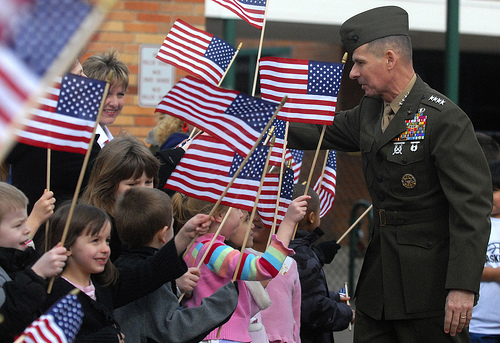

 a man in a red shirt is standing in front of a crowd of people 


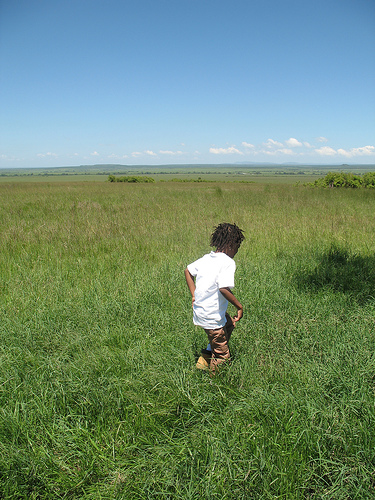

 a man in a red shirt is running on a beach 


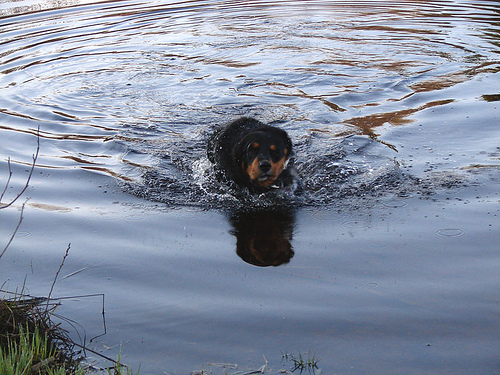

 a dog is running through the water 


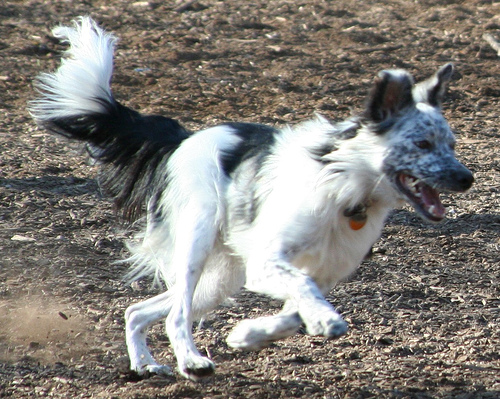

 a dog is running in the grass 


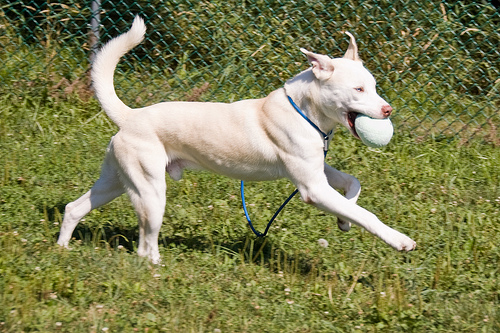

 a dog is running in the grass 


In [59]:
for rand_img in sample(list(test.image.unique()), 5):
    print(legende_predite(rand_img, model))

### **6.2. Évaluations**

